In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Open the csv file of actors
#financials = pd.read_csv('./../cleaned_datasets/financial_data_no_budget.csv')
financials_bud = pd.read_csv('./../cleaned_datasets/financial_data.csv')
movies = pd.read_csv('./../cleaned_datasets/movies_clean.csv')

# 1. Data prep

In [2]:
data = financials_bud.merge(movies, left_on=["original_title", "year_release", "runtime"], right_on=["name", "year_release" , "runtime"], how='left')
data = data.drop(columns=["revenue", "name", 'wikipedia_id', 'freebase_id', 'release_date',
       'languages', 'countries', 'genres'])
data = data.dropna(subset=["revenue_final_adjusted" , "budget_adjusted", "averageRating"])
data = data[data['revenue_final_adjusted'] != 0]
data = data[data['revenue_final_adjusted'] >= 1000]
data["rev_per_bud"] = data["revenue_final_adjusted"] / data["budget_adjusted"]
data["log_rev"] = np.log(data["revenue_final_adjusted"])
data

,original_title,runtime,year_release,budget_adjusted,revenue_final_adjusted,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,rev_per_bud,log_rev
0,The Cheat,59.0,1915,173795,1379092,6.5,2709.0,0.000000,0.333333,0.0,3.0,7.935165,14.136936
7,The Unholy Three,86.0,1925,1034080,7067892,7.2,2117.0,0.000000,3.250000,0.0,26.0,6.834957,15.771073
13,Flesh and the Devil,112.0,1926,3744778,6606069,7.6,4533.0,0.000000,1.444444,0.0,13.0,1.764075,15.703499
17,Lights of New York,57.0,1928,752971,12047543,5.7,907.0,0.000000,2.000000,0.0,6.0,16.000009,16.304371
19,West of Zanzibar,65.0,1928,2600261,9246489,7.2,1915.0,0.250000,7.750000,1.0,31.0,3.555985,16.039754
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4588,Killing Them Softly,97.0,2012,19515604,49349062,6.2,150251.0,0.333333,8.533333,5.0,128.0,2.528698,17.714429
4595,Bachelorette,87.0,2012,3903120,15544769,5.3,48378.0,0.000000,6.000000,0.0,66.0,3.982652,16.559235
4598,The Cold Light of Day,93.0,2012,26020805,21940200,4.9,38954.0,0.076923,5.230769,1.0,68.0,0.843179,16.903831
4600,That's My Boy,116.0,2012,91072819,75536274,5.5,106484.0,0.000000,6.000000,0.0,90.0,0.829405,18.140124


# 1.1 First data viz

In [33]:
# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Revenues Over the Years', 'Ratings Over the Years'))

# First subplot for Revenues by Year
fig.add_trace(
    go.Scatter(
        x=data['year_release'],
        y=data['revenue_final_adjusted'],
        mode='markers',
        text=data['original_title'],  # This line sets the hover text to the movie names
        hoverinfo='text+x+y',  # This line configures the tooltip to show the hover text and the x, y values
        name='Revenue'
    ),
    row=1, col=1
)

# Second subplot for Ratings by Year
fig.add_trace(
    go.Scatter(
        x=data['year_release'],
        y=data['averageRating'],
        mode='markers',
        text=data['original_title'],  # This line sets the hover text to the movie names
        hoverinfo='text+x+y',  # This line configures the tooltip to show the hover text and the x, y values
        name='Rating'    ),
    row=1, col=2
)

# Update layout if needed
fig.update_layout(
    title_text='Movie Revenues and Ratings Over the Years',
    xaxis_title='Year',
    yaxis_title='Revenue',
    xaxis2_title='Year',
    yaxis2_title='Rating',
    showlegend=False
)

# Show the figure
fig.show()

fig.write_html("../html_graphics/fin_first_viz.html")
#fig.write_image("plot.png")


# 2. Correlation Analysis

In [21]:
correlation = data[['averageRating', 'revenue_final_adjusted']].corr(method='pearson')
print(correlation)

                        averageRating  revenue_final_adjusted
averageRating                 1.00000                 0.23622
revenue_final_adjusted        0.23622                 1.00000


Slight positive correlation

# 3. Scatter plot with regression line

In [16]:
fig = px.scatter(
    data, 
    x='averageRating', 
    y='revenue_final_adjusted', 
    trendline='ols', 
    title='Relationship between Rating and Revenue',
    labels={'averageRating': 'Average Rating', 'revenue_final_adjusted': 'Revenue (CPI Adjusted)'},
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.show()
#fig.write_html("plot.html")
#fig.write_image("plot.png")

# 4. Simple linear regression

could also add budget

In [5]:
X = data[['averageRating']]
y = data['revenue_final_adjusted']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     revenue_final_adjusted   R-squared:                       0.056
Model:                                OLS   Adj. R-squared:                  0.055
Method:                     Least Squares   F-statistic:                     103.4
Date:                    Mon, 18 Dec 2023   Prob (F-statistic):           1.21e-23
Time:                            13:10:49   Log-Likelihood:                -36556.
No. Observations:                    1752   AIC:                         7.312e+04
Df Residuals:                        1750   BIC:                         7.313e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

In [22]:
# Fit the model
X = data[['averageRating']]
y = data['revenue_final_adjusted']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Extract coefficients
slope, intercept = model.params['averageRating'], model.params['const']

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['averageRating'], y=data['revenue_final_adjusted'], 
                         mode='markers', name='Data Points'))

# Add regression line
fig.add_trace(go.Scatter(x=data['averageRating'], y=intercept + slope * data['averageRating'], 
                         mode='lines', name='Regression Line'))

# Update layout
fig.update_layout(
    title='Regression Analysis: Rating vs. Revenue',
    xaxis_title='Average Rating',
    yaxis_title='Revenue (CPI Adjusted)'
)

# Optionally, add annotations with key statistics
# This is a basic example, you can format it as needed
fig.add_annotation(x=max(data['averageRating']), y=max(data['revenue_final_adjusted']),
                   text=f'R-squared: {model.rsquared:.2f}\n' +
                        f'Coefficient: {slope:.2f}',
                   showarrow=False, yshift=10)

fig.show()

In [34]:
# Define the independent variables (including budget) and the dependent variable
X = data[['averageRating', 'budget_adjusted']]
y = data['revenue_final_adjusted']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Build the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

# Extract coefficients
slope, intercept = model.params['averageRating'
                                ], model.params['const']

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['averageRating'], y=data['revenue_final_adjusted'], 
                         mode='markers', name='Data Points'))

# Add regression line
fig.add_trace(go.Scatter(x=data['averageRating'], y=intercept + slope * data['averageRating'], 
                         mode='lines', name='Regression Line'))

# Update layout
fig.update_layout(
    title='Regression Analysis: Rating vs. Revenue',
    xaxis_title='Average Rating',
    yaxis_title='Revenue (CPI Adjusted)'
)

# Optionally, add annotations with key statistics
# This is a basic example, you can format it as needed
fig.add_annotation(x=max(data['averageRating']), y=max(data['revenue_final_adjusted']),
                   text=f'R-squared: {model.rsquared:.2f}\n' +
                        f'Coefficient: {slope:.2f}',
                   showarrow=False, yshift=10)

fig.show()
fig.write_html("../html_graphics/fin_lin_reg.html")


                              OLS Regression Results                              
Dep. Variable:     revenue_final_adjusted   R-squared:                       0.317
Model:                                OLS   Adj. R-squared:                  0.317
Method:                     Least Squares   F-statistic:                     406.6
Date:                    Mon, 18 Dec 2023   Prob (F-statistic):          9.53e-146
Time:                            15:17:55   Log-Likelihood:                -36272.
No. Observations:                    1752   AIC:                         7.255e+04
Df Residuals:                        1749   BIC:                         7.257e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
co

# 5. Residual Analysis

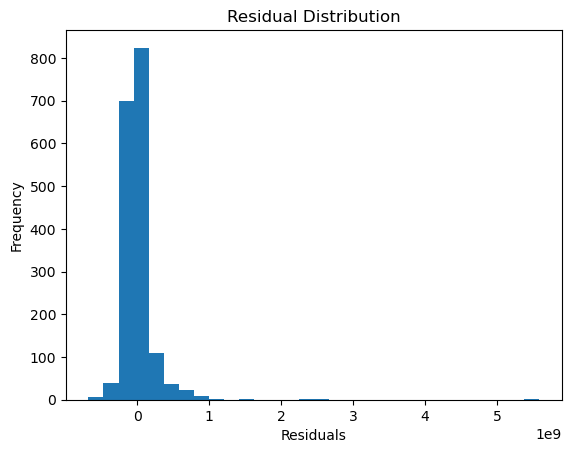

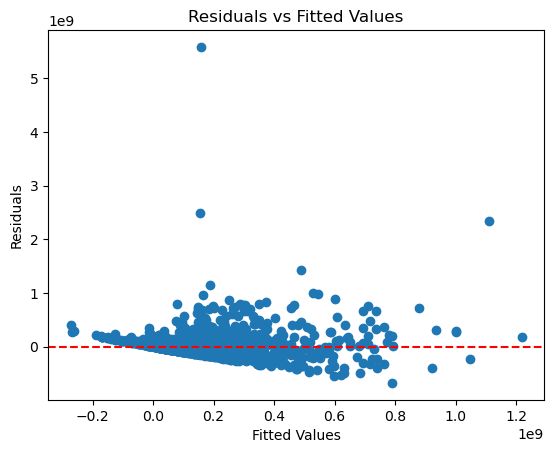

In [8]:
residuals = model.resid
plt.hist(residuals, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for residuals
plt.scatter(model.predict(), residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


# 6. Quartiles group comparison

In [39]:
# Calculate quartiles
quartiles = data['averageRating'].quantile([0.25, 0.5, 0.75])

print("quartiles: ", quartiles)

# Function to categorize each movie based on its rating quartile
def rating_category(rating):
    if rating <= quartiles[0.25]:
        return f"Low (<{quartiles[0.25]:.1f})"
    elif rating <= quartiles[0.5]:
        return f"Lower-Middle (<{quartiles[0.5]:.1f})"
    elif rating <= quartiles[0.75]:
        return f"Upper-Middle (<{quartiles[0.75]:.1f})"
    else:
        return f"High (≥{quartiles[0.75]:.1f})"

# Apply the function to create a new column for rating category
data['RatingCategory'] = data['averageRating'].apply(rating_category)

# Group by the new category and calculate mean revenue and standard deviation
category_stats = data.groupby('RatingCategory')['revenue_final_adjusted'].agg(['mean', 'std'])

# Display the results
print(category_stats)

# Create the Plotly boxplot with specified category order and titles
fig = px.box(data, x='RatingCategory', y='revenue_final_adjusted', 
             title="Boxplot of Revenue by Rating Category",
             labels={'revenue_final_adjusted': 'Revenue (CPI Adjusted)', 'RatingCategory': 'Rating Category'},
             category_orders={
                 "RatingCategory": [
                     f"Low (<{quartiles[0.25]:.1f})", 
                     f"Lower-Middle (<{quartiles[0.5]:.1f})", 
                     f"Upper-Middle (<{quartiles[0.75]:.1f})", 
                     f"High (≥{quartiles[0.75]:.1f})"
                 ]
             },
             points='all', # to display all points
             color='RatingCategory')

# Update the layout to use a logarithmic scale for the y-axis
fig.update_layout(yaxis_type="log")

fig.show()
# Save the plot as HTML
fig.write_html("../html_graphics/fin_quartiles_box.html")


quartiles:  0.25    5.9
0.50    6.5
0.75    7.1
Name: averageRating, dtype: float64
                             mean           std
RatingCategory                                 
High (≥7.1)          2.717789e+08  4.548920e+08
Low (<5.9)           9.244641e+07  1.315135e+08
Lower-Middle (<6.5)  1.345948e+08  2.017946e+08
Upper-Middle (<7.1)  1.671323e+08  2.303929e+08


# 7. Pair matching / Propensity score

In [40]:
import statsmodels.formula.api as smf
import networkx as nx

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

# Standardize continuous features
data['budget_adjusted_std'] = (data['budget_adjusted'] - data['budget_adjusted'].mean()) / data['budget_adjusted'].std()
data['year_release_std'] = (data['year_release'] - data['year_release'].mean()) / data['year_release'].std()

# Define high rating
high_rating_threshold = data['averageRating'].quantile(0.5)
data['high_rating'] = (data['averageRating'] >= high_rating_threshold).astype(int)


# Calculate Propensity Scores
mod = smf.logit(formula='high_rating ~ budget_adjusted_std + year_release_std', data=data)
res = mod.fit()
data['Propensity_score'] = res.predict()

# Separate the treatment and control groups
treatment_df = data[data['high_rating'].astype(bool)]
control_df = data[~data['high_rating'].astype(bool)]

# Create a Network Graph
G = nx.Graph()

# Add edges with weights based on propensity score similarity
for control_idx, control_row in control_df.iterrows():
    for treatment_idx, treatment_row in treatment_df.iterrows():
        # Weight based on the inverse of the absolute difference in propensity scores
        weight = get_similarity(control_row['Propensity_score'],treatment_row['Propensity_score'])
        G.add_edge(control_idx, treatment_idx, weight=weight)

# Find the Maximum Weight Matching
matching = nx.max_weight_matching(G, maxcardinality=True)

# Extract matched indices into a flat list
matched_indices_flat = [idx for pair in matching for idx in pair]

# Use the flat list of indices to get the matched data
matched_data = data.loc[matched_indices_flat]

# Calculate and compare average revenues
average_revenue_high = matched_data[matched_data['high_rating'].astype(bool)]['revenue_final_adjusted'].mean()
average_revenue_low = matched_data[~matched_data['high_rating'].astype(bool)]['revenue_final_adjusted'].mean()

print(f"Average Revenue for High Rated Movies: {average_revenue_high}")
print(f"Average Revenue for Matched Low Rated Movies: {average_revenue_low}")

Optimization terminated successfully.
         Current function value: 0.669426
         Iterations 5
Average Revenue for High Rated Movies: 219224169.78588516
Average Revenue for Matched Low Rated Movies: 106129755.69976076


## 8. T-test

In [41]:
from scipy import stats

# Extract revenues for high-rated and low-rated movies from matched pairs
revenues_high = matched_data[matched_data['high_rating'] == 1]['revenue_final_adjusted']
revenues_low = matched_data[matched_data['high_rating'] == 0]['revenue_final_adjusted']

# Conduct the paired t-test
t_stat, p_value = stats.ttest_rel(revenues_high, revenues_low)

print("Paired t-test results under hypothesis that the two cases (high and low rating) have identical average (expected) revenue:")
print(f"T-statistic: {t_stat}, P-value: {p_value}")
print(f"Reject the null hypothesis (p-value < 0.05): {p_value < 0.05}")

Paired t-test results under hypothesis that the two cases (high and low rating) have identical average (expected) revenue:
T-statistic: 9.221131982192027, P-value: 2.344472368158773e-19
Reject the null hypothesis (p-value < 0.05): True


Therefore there is a signficant difference between the high rating and the low rating group.

In [42]:
# Calculate the mean and standard error of the mean (SEM) for treated and control groups
treated_mean = matched_data[matched_data['high_rating'] == 1]['revenue_final_adjusted'].mean()
treated_sem = matched_data[matched_data['high_rating'] == 1]['revenue_final_adjusted'].sem()

control_mean = matched_data[matched_data['high_rating'] == 0]['revenue_final_adjusted'].mean()
control_sem = matched_data[matched_data['high_rating'] == 0]['revenue_final_adjusted'].sem()

# Calculate the 95% CI using 1.96 * SEM
treated_ci = 1.96 * treated_sem
control_ci = 1.96 * control_sem

# Create error bar arguments for 95% CI
error_bars_treated = dict(type='data', array=[treated_ci], visible=True)
error_bars_control = dict(type='data', array=[control_ci], visible=True)

# Create the bar chart with 95% CI error bars
fig = go.Figure(data=[
    go.Bar(name='Treated', x=['Treated'], y=[treated_mean], error_y=error_bars_treated),
    go.Bar(name='Control', x=['Control'], y=[control_mean], error_y=error_bars_control)
])

# Update the layout
fig.update_layout(
    title='Revenue with 95% Confidence Intervals',
    xaxis_title='Group',
    yaxis_title='Revenue',
    yaxis=dict(range=[0, max(treated_mean + treated_ci, control_mean + control_ci)*1.2])  # Adjust y-axis range if necessary
)

# Show the figure
fig.show()
fig.write_html("../html_graphics/fin_revenue_paired.html")

In [43]:
years = range(1980, 2013)  # From 1980 to 2012 inclusive

# Initialize counter for years where treated revenue is higher
treated_higher_count = 0

# Pre-calculate the y-axis range
all_means = []
all_cis = []
for year in years:
    current_year_data = matched_data[matched_data['year_release'] == year]
    treated = current_year_data[current_year_data['high_rating'] == 1]['revenue_final_adjusted']
    control = current_year_data[current_year_data['high_rating'] == 0]['revenue_final_adjusted']
    treated_mean = treated.mean()
    control_mean = control.mean()
    if treated_mean > control_mean:
        treated_higher_count += 1
    all_means.append(treated_mean)
    all_means.append(control_mean)
    all_cis.append(1.96 * treated.sem())
    all_cis.append(1.96 * control.sem())

# Determine the maximum upper limit for the y-axis
max_upper_limit = max([mean + ci for mean, ci in zip(all_means, all_cis)])

# Create figure with subplots
fig = make_subplots(rows=1, cols=1)

# Add traces for each year, initially invisible
traces = []
for i, year in enumerate(years):
    current_year_data = matched_data[matched_data['year_release'] == year]
    treated = current_year_data[current_year_data['high_rating'] == 1]['revenue_final_adjusted']
    control = current_year_data[current_year_data['high_rating'] == 0]['revenue_final_adjusted']
    treated_mean = treated.mean()
    control_mean = control.mean()
    treated_ci = 1.96 * treated.sem()
    control_ci = 1.96 * control.sem()
    
    trace = go.Bar(
        visible=(i == 0),  # Make the first trace visible
        name=f"Year {year}",
        x=["Treated", "Control"],
        y=[treated_mean, control_mean],
        error_y=dict(type="data", array=[treated_ci, control_ci], visible=True),
        marker_color=['#636EFA', '#EF553B']  # Different colors for each bar
    )
    traces.append(trace)

# Add traces to the figure
for trace in traces:
    fig.add_trace(trace)

# Create and add slider
steps = []
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(traces)},
              {"title": f"Year: {year}"}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    step["label"] = str(year)  # Set the slider label to the year

    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to add the slider and fix the y-axis range
fig.update_layout(
    sliders=sliders,
    title=f"Year: {years[0]}",
    yaxis=dict(title='Revenue', range=[0, max_upper_limit])
)

# Show the figure
fig.show()
fig.write_html("../html_graphics/fin_revenue_paired_years.html")

# Calculate the percentage
percentage_treated_higher = (treated_higher_count / len(years)) * 100
print(f"The percentage of years where the treated group had higher revenue than the control group is: {percentage_treated_higher:.2f}%")


The percentage of years where the treated group had higher revenue than the control group is: 93.94%
